In [130]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import re
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os

In [131]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'
Ravdess_Path='../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24'
Savee_Path='../input/speech-emotion-recognition-en/Savee/'
Tess_Path='../input/speech-emotion-recognition-en/Tess/'

#### CREMA-D dataset

In [132]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,disgust,../input/speech-emotion-recognition-en/Crema//...
1,happy,../input/speech-emotion-recognition-en/Crema//...
2,happy,../input/speech-emotion-recognition-en/Crema//...
3,disgust,../input/speech-emotion-recognition-en/Crema//...
4,disgust,../input/speech-emotion-recognition-en/Crema//...


In [133]:
Crema_df['Emotion'].unique()

array(['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry'],
      dtype=object)

#### Ravdess DataFrame

   Вот идентификаторы файлов в соответствии с официальным веб-сайтом RAVDESS:

   - Модальность (01 = полный AV, 02 = только видео, 03 = только аудио).
   - Голосовой канал (01 = речь, 02 = песня).
   - Эмоция (01 = нейтральное, 02 = спокойное, 03 = счастливое, 04 = грустное, 05 = злое, 06 = испуганное, 07 = отвращение, 08 = удивление).
   - Эмоциональная интенсивность (01 = нормальная, 02 = сильная). Примечание: Нет сильной интенсивности для эмоции 'нейтральное'.
   - Утверждение (01 = "Дети разговаривают у двери", 02 = "Собаки сидят у двери").
   - Повторение (01 = 1-е повторение, 02 = 2-е повторение).
   - Актер (01 до 24. Актеры с нечетными номерами - мужчины, актеры с четными номерами - женщины).

   Вот пример имени аудиофайла: `02-01-06-01-02-01-12.mp4`. Это означает метаданные для аудиофайла:

   - Только видео (02)
   - Речь (01)
   - Испуганное (06)
   - Нормальная интенсивность (01)
   - Утверждение "собаки" (02)
   - 1-е повторение (01)
   - 12-й актер (12) - Женщина (так как идентификационный номер актера четный)





In [134]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

,Emotion,File_Path
0,surprise,../input/speech-emotion-recognition-en/Ravdess...
1,neutral,../input/speech-emotion-recognition-en/Ravdess...
2,disgust,../input/speech-emotion-recognition-en/Ravdess...
3,disgust,../input/speech-emotion-recognition-en/Ravdess...
4,neutral,../input/speech-emotion-recognition-en/Ravdess...


In [135]:
Ravdess_df['Emotion'].unique()

array(['surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry'],
      dtype=object)

#### Saveee Dataset
Аудиофайлы в этом датасете именуются с использованием префиксных букв, описывающих классы эмоций следующим образом:
- 'a' = 'anger'
- 'd' = 'disgust'
- 'f' = 'fear'
- 'h' = 'happiness'
- 'n' = 'neutral'
- 'sa' = 'sadness'
- 'su' = 'surprise'

In [136]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

,Emotion,File_Path
0,happy,../input/speech-emotion-recognition-en/Savee//...
1,fear,../input/speech-emotion-recognition-en/Savee//...
2,happy,../input/speech-emotion-recognition-en/Savee//...
3,disgust,../input/speech-emotion-recognition-en/Savee//...
4,angry,../input/speech-emotion-recognition-en/Savee//...


In [137]:
Savee_df['Emotion'].unique()

array(['happy', 'fear', 'disgust', 'angry', 'surprise', 'neutral', 'sad'],
      dtype=object)

#### TESS dataset

In [138]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

,Emotion,File_Path
0,fear,../input/speech-emotion-recognition-en/Tess/YA...
1,fear,../input/speech-emotion-recognition-en/Tess/YA...
2,fear,../input/speech-emotion-recognition-en/Tess/YA...
3,fear,../input/speech-emotion-recognition-en/Tess/YA...
4,fear,../input/speech-emotion-recognition-en/Tess/YA...


In [139]:
Tess_df['Emotion'].unique()

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'surprise', 'happy'],
      dtype=object)

In [140]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df],axis=0)
main_df.shape

(12162, 2)

#### Data Visualisation and Exploration

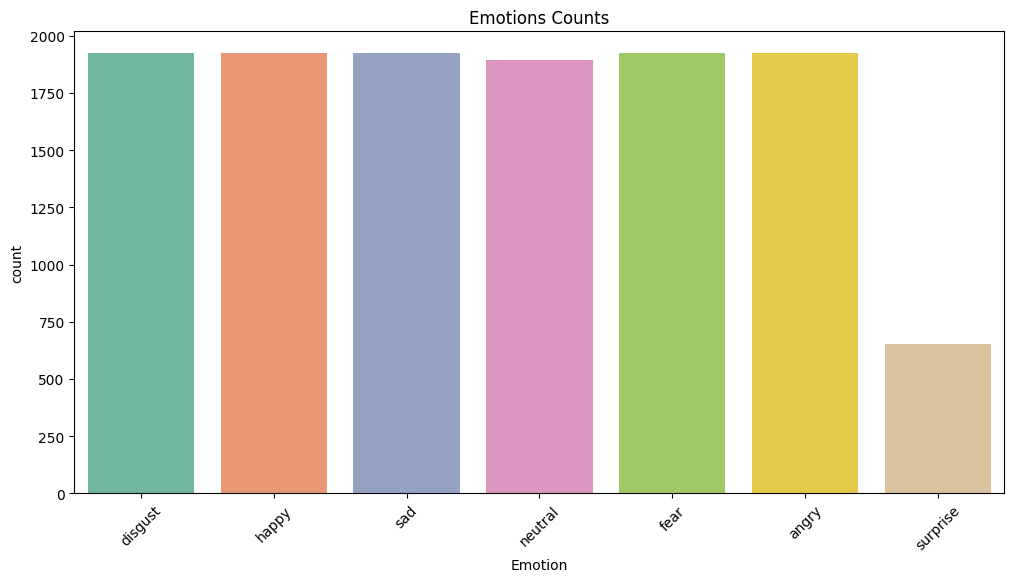

In [141]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

In [142]:
emotion_names=main_df['Emotion'].unique()

In [143]:
colors={'disgust':'#804E2D','happy':'#F19C0E','sad':'#478FB8','neutral':'#4CB847','fear':'#7D55AA','angry':'#C00808','surprise':'#EE00FF'}

Мы также можем строить волновые графики (waveplots) и спектрограммы для аудиосигналов.

- **Waveplots (Волновые графики)** - Waveplots позволяют нам определить громкость аудио в конкретный момент времени.

- **Spectograms (Спектрограммы)** - Спектрограмма представляет собой визуальное представление спектра частот звука или других сигналов в зависимости от времени. Это представление изменения частот по отношению к времени для заданных аудио/музыкальных сигналов.


In [144]:
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr,color=color)

In [145]:
def spectogram(data,sr,emotion):
    audio=librosa.stft(data)
    audio_db=librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for spectogram',size=17)
    librosa.display.specshow(audio_db,sr=sr,x_axis='time',y_axis='hz')

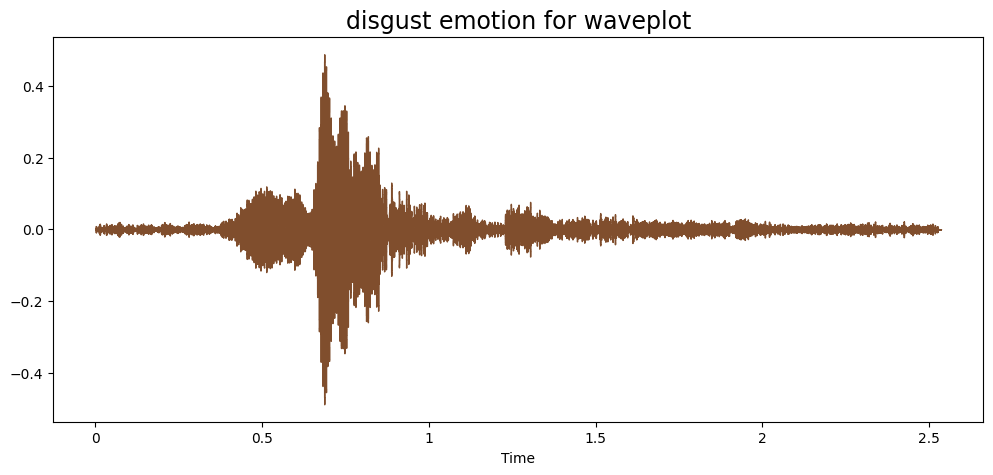

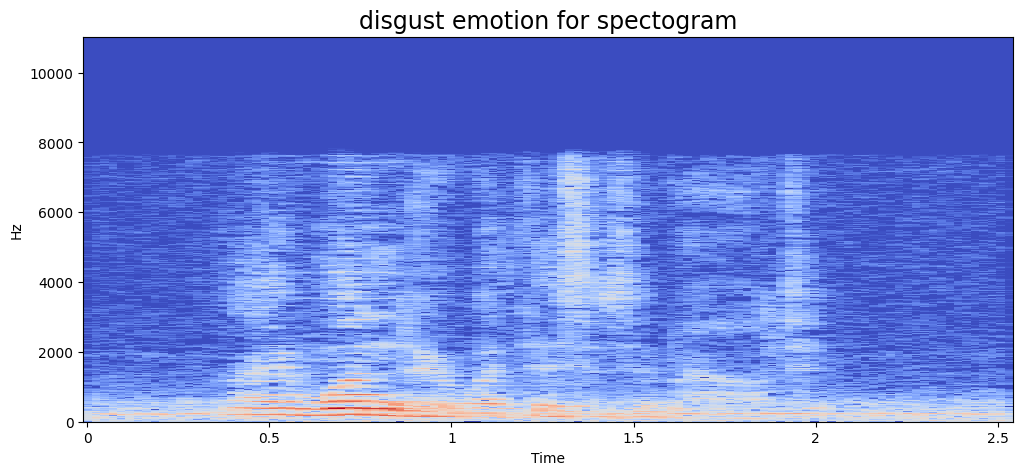

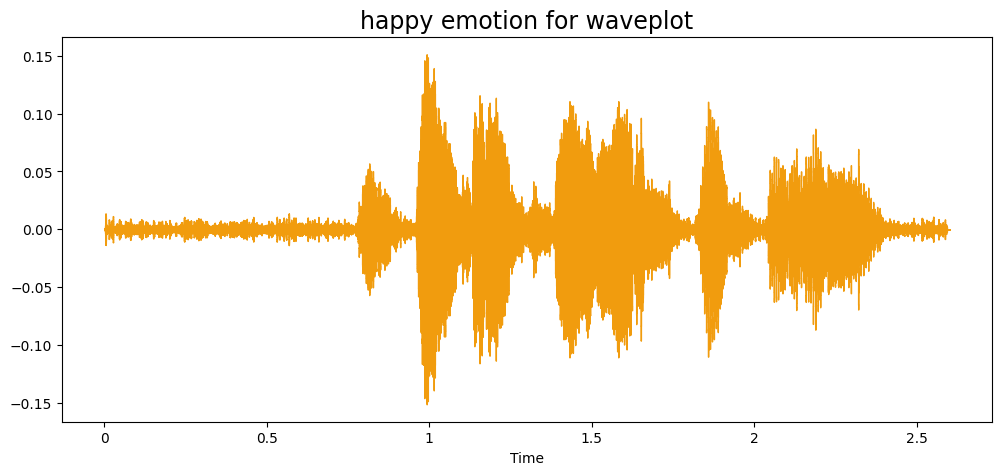

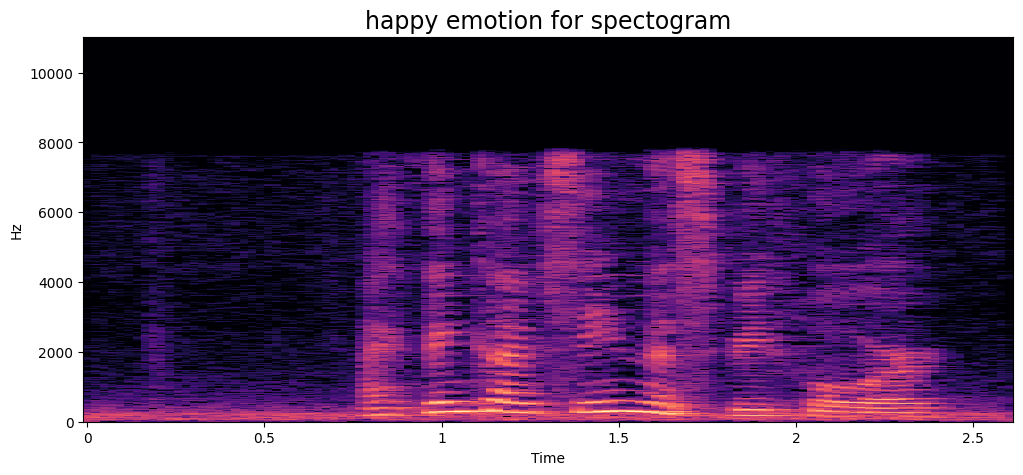

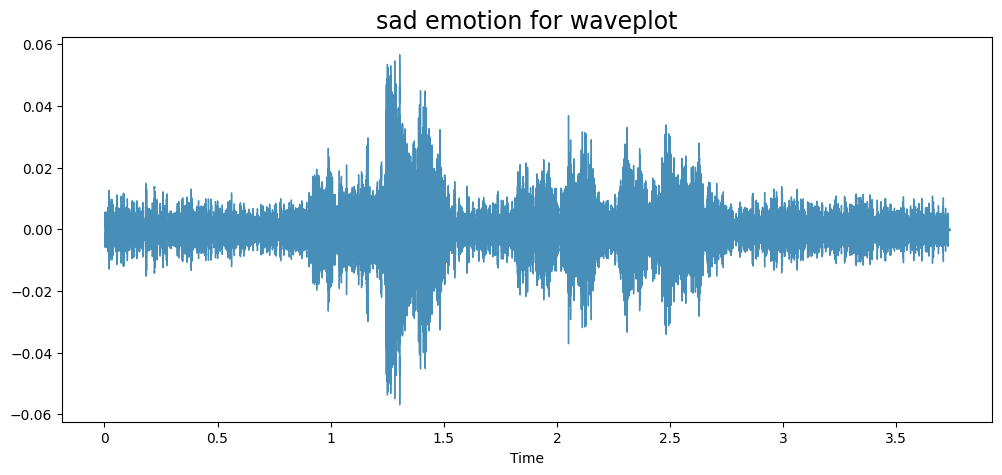

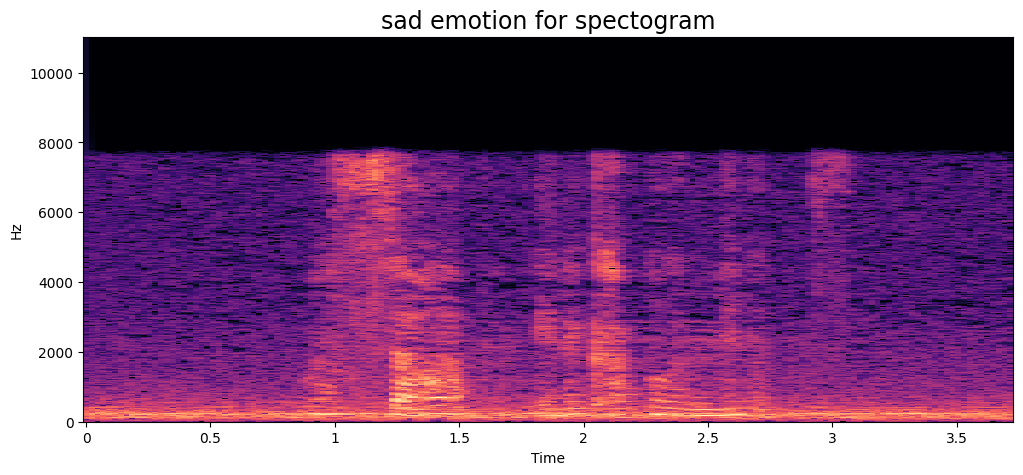

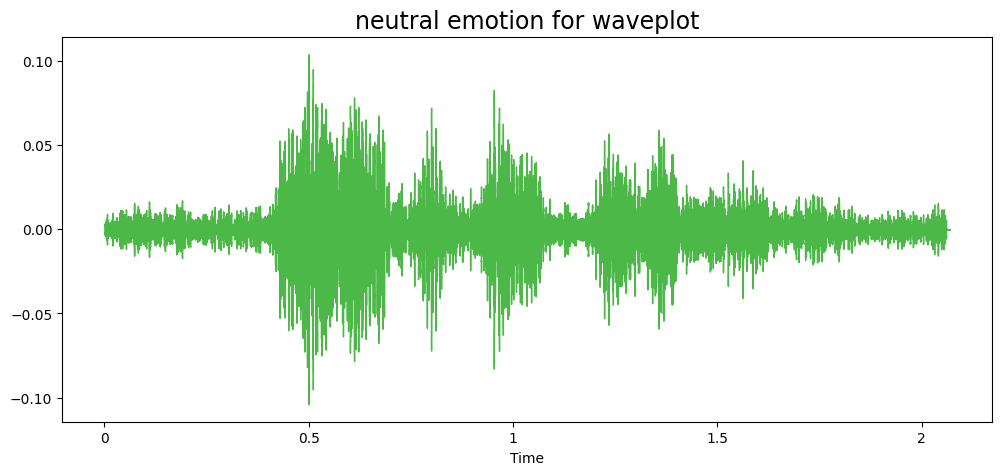

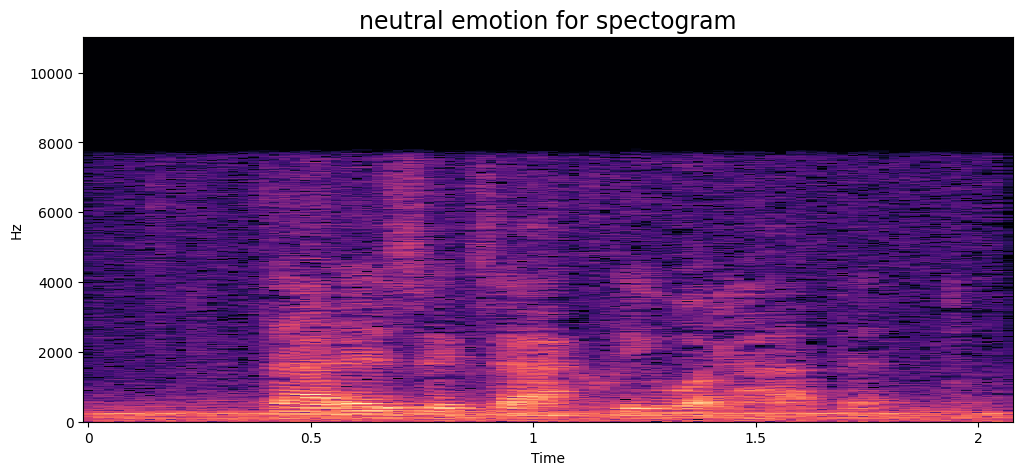

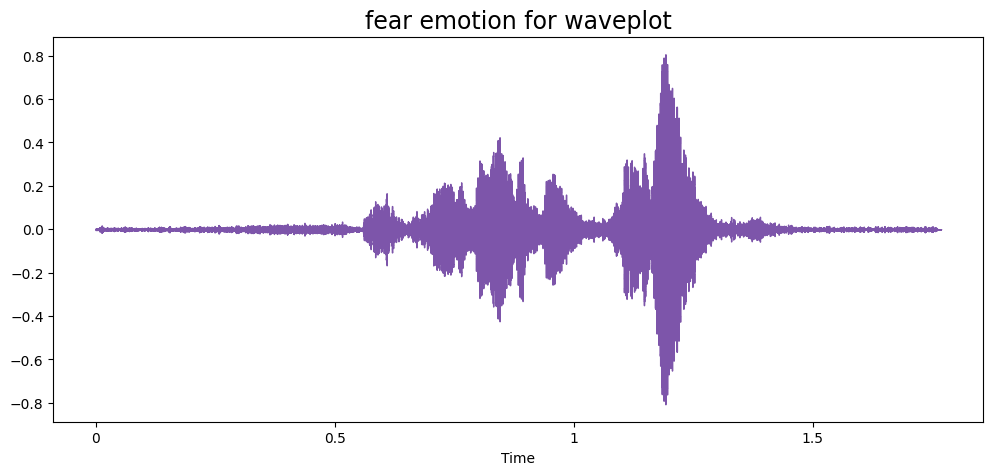

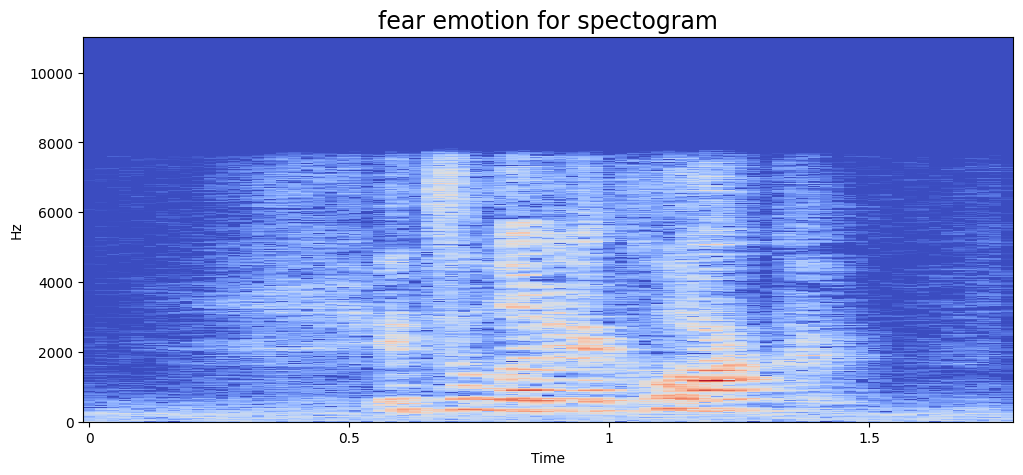

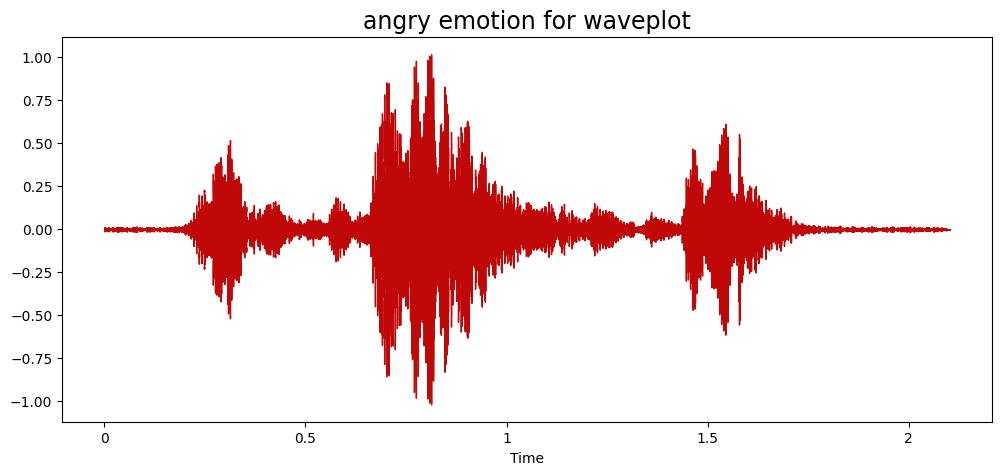

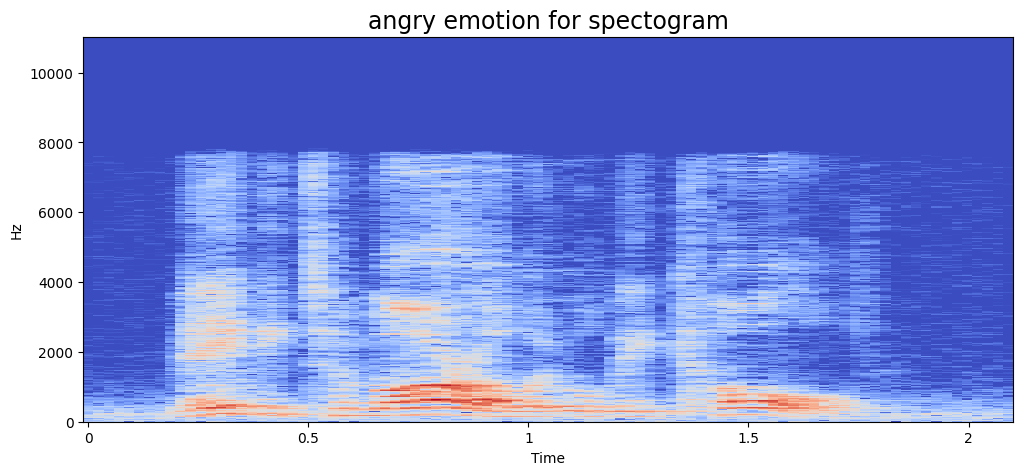

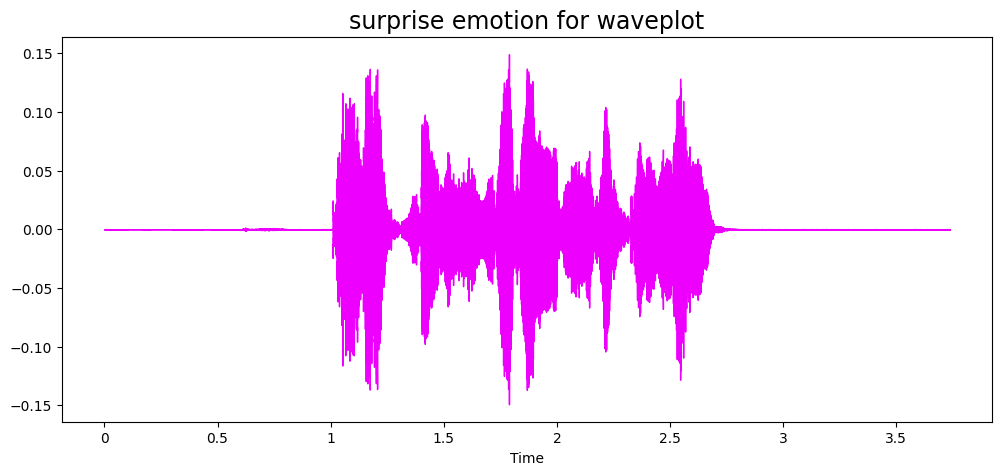

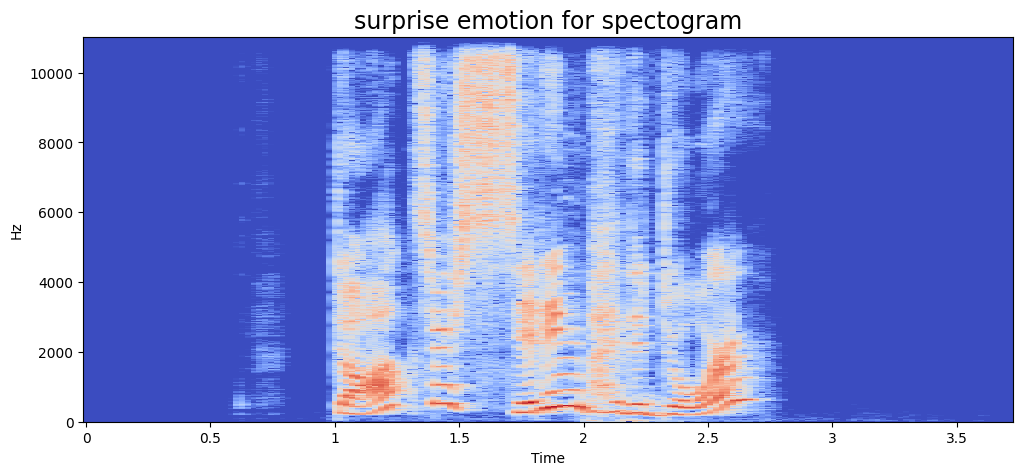

In [146]:
audio_path=[]
for emotion in emotion_names:
    path=np.array(main_df['File_Path'][main_df['Emotion']==emotion])[1]
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,colors[emotion])
    spectogram(data,sr,emotion)
    audio_path.append(path)

#### Data Augmentation

- Аугментация данных - это процесс создания новых синтетических образцов данных путем внесения небольших изменений в наш исходный набор данных для обучения.
- Для генерации синтетических данных для звука мы можем применять внедрение шума, сдвиг времени, изменение высоты тона и скорости.
- Цель состоит в том, чтобы сделать нашу модель инвариантной к этим изменениям и улучшить ее способность к обобщению.
- Для того чтобы это работало, добавление изменений должно сохранять тот же самый ярлык, что и у исходного образца для обучения.
- В случае изображений аугментацию данных можно выполнять путем смещения изображения, масштабирования, вращения ...


Давайте сначала проверим, какие техники аугментации работают лучше для нашего набора данных.


In [147]:
# Function to add noise to an audio signal
def add_noise(data, random=False, rate=0.035, threshold=0.075):
    if random:
        rate = np.random.random() * threshold
    noise = rate * np.random.uniform() * np.amax(data)
    augmented_data = data + noise * np.random.normal(size=data.shape[0])
    return augmented_data

# Function to shift an audio signal
def shifting(data, rate=1000):
    augmented_data = int(np.random.uniform(low=-5, high=5) * rate)
    augmented_data = np.roll(data, augmented_data)
    return augmented_data

# Function to change pitch of an audio signal
def pitching(data, sr, pitch_factor=0.7, random=False):
    if random:
        pitch_factor = np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr, pitch_factor)

# Function to stretch an audio signal
def stretching(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


In [148]:
data,sr=librosa.load(audio_path[6])

**1. **Simple Audio****

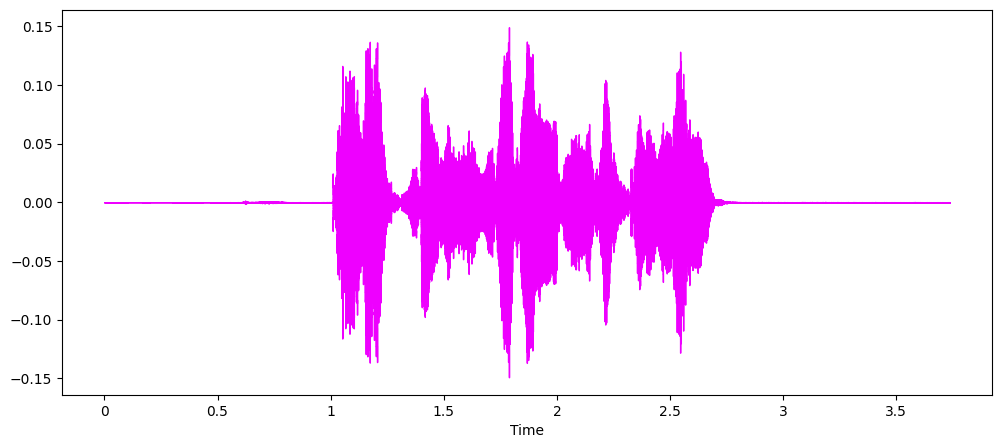

In [149]:
plt.figure(figsize=(12,5))
librosa.display.waveshow(data,sr = sr,color='#EE00FF')
IPython.display.Audio(audio_path[6])

**2. Noise Injection**

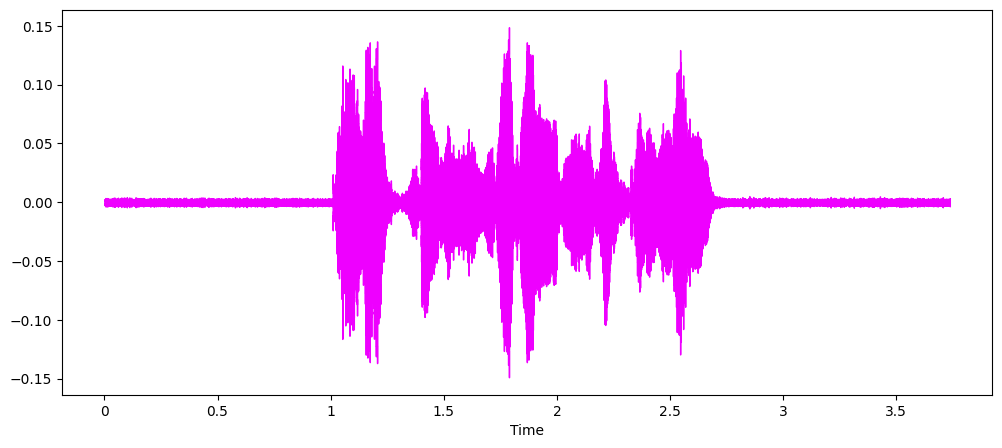

In [150]:
noised_audio=add_noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(noised_audio,sr=sr,color='#EE00FF')
IPython.display.Audio(noised_audio,rate=sr)


**3. Shifting**

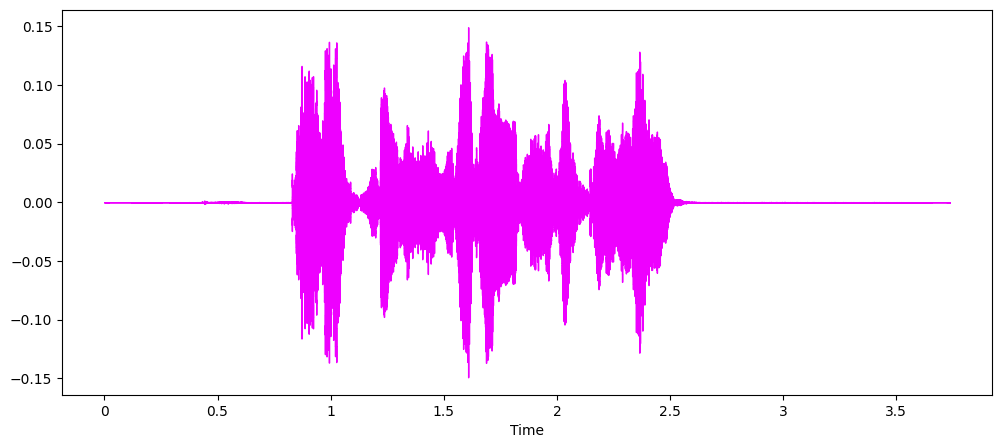

In [151]:
shifted_audio=shifting(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(shifted_audio,sr=sr,color='#EE00FF')
IPython.display.Audio(shifted_audio,rate=sr)

#### Feature Extraction

- Извлечение признаков — очень важная часть анализа и поиска связей между разными вещами. Поскольку мы уже знаем, что данные, предоставленные в виде звука, не могут быть поняты моделями напрямую, поэтому нам необходимо преобразовать их в понятный формат, для которого используется извлечение признаков.

- Как сказано там, с помощью частоты дискретизации и выборочных данных можно выполнить несколько преобразований, чтобы извлечь из них ценные функции.



1. **Скорость пересечения нуля (Zero Crossing Rate):**
   - Скорость изменения знака сигнала в течение определенного кадра.

2. **Энергия:**
   - Сумма квадратов значений сигнала, нормализованная по соответствующей длине кадра.

3. **Энтропия энергии:**
   - Энтропия нормализованных энергий подкадров. Мера резких изменений.

4. **Спектральный центроид:**
   - Центр тяжести спектра.

5. **Спектральное распределение (Spectral Spread):**
   - Второй центральный момент спектра.

6. **Спектральная энтропия:**
   - Энтропия нормализованных спектральных энергий для набора подкадров.

7. **Спектральный поток:**
   - Квадрат разницы между нормализованными величинами спектров двух последовательных кадров.

8. **Спектральный спад (Spectral Rolloff):**
   - Частота, ниже которой сосредоточено 90% распределения амплитуды спектра.

9. **MFCC (Частотные кепстральные коэффициенты Mel):**
    - Кепстральное представление с нелинейным распределением полос частот.

10. **Chroma Vector:**
    - 12-элементное представление спектральной энергии, представляющее 12 равнотемперированных классов высоты тона музыки западного типа (интервал в полутонах).

11. **Отклонение цветности (Chroma Deviation):**
    - Стандартное отклонение 12 коэффициентов цветности.
    
    
    

- **В этом проекте я не углубляюсь в процесс выбора характеристик, чтобы проверить, какие из них подходят для нашего набора данных. Я извлекаю только 3 характеристики:**

1. **Zero Crossing Rate (Скорость пересечения нуля):**
   - Измеряет скорость изменения знака сигнала в течение определенного кадра.

2. **MFCC (Частотные кепстральные коэффициенты Mel):**
   - Кепстральное представление с нелинейным распределением полос частот.

3. **RMS (Root Mean Square) значение:**
   - Корень из среднего квадратического значения, измеряющий средний уровень амплитуды сигнала.


In [152]:
# Feature extraction functions

# Function to compute Zero Crossing Rate (ZCR) of an audio signal
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# Function to compute Root Mean Square (RMS) Value of an audio signal
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# Function to compute Mel-frequency cepstral coefficients (MFCC) of an audio signal
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

# Function to extract features from an audio file
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                       ))
    return result

# Function to get features from an audio file with optional data augmentation
def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data, sr)
    audio = np.array(aud)
    
    # Data augmentation: add noise
    noised_audio = add_noise(data, random=True)
    aud2 = extract_features(noised_audio, sr)
    audio = np.vstack((audio, aud2))
    
    # Data augmentation: pitch shift
    pitched_audio = pitching(data, sr, random=True)
    aud3 = extract_features(pitched_audio, sr)
    audio = np.vstack((audio, aud3))
    
    # Data augmentation: pitch shift + noise
    pitched_audio1 = pitching(data, sr, random=True)
    pitched_noised_audio = add_noise(pitched_audio1, random=True)
    aud4 = extract_features(pitched_noised_audio, sr)
    audio = np.vstack((audio, aud4))
    
    return audio


In [153]:
X, Y = [], []

# Loop through each audio file in the main dataframe
for path, emotion, index in zip(main_df.File_Path, main_df.Emotion, range(main_df.File_Path.shape[0])):
    # Extract features for each audio file
    features = get_features(path)
    # Append features and corresponding emotion to X and Y lists
    for i in features:
        X.append(i)
        Y.append(emotion)

# Create a new dataframe with features and emotions, then save it to a CSV file
df = pd.DataFrame({'Feature': X, 'Emotion': Y})
df.to_csv('processed_data.csv', index=False)


In [154]:
processed_data_path='../processed_data.csv'
df=pd.read_csv(processed_data_path)
df.shape


(48648, 2377)

In [155]:
df=df.fillna(0)
print(df.isna().any())
df.shape

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


(48648, 2377)

In [156]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
0,0.121094,0.187012,0.234863,0.244629,0.244629,0.239746,0.231445,0.178711,0.123535,0.073730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
1,0.121094,0.188965,0.238770,0.249512,0.254395,0.251465,0.246094,0.195312,0.137207,0.083496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
2,0.124512,0.173828,0.222656,0.236816,0.246094,0.251465,0.229980,0.169434,0.107422,0.063965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
3,0.125488,0.176270,0.230469,0.250977,0.260254,0.280273,0.257812,0.195801,0.136230,0.078613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
4,0.016113,0.021484,0.029297,0.030762,0.033691,0.036133,0.038574,0.046875,0.054688,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
5,0.020996,0.030273,0.043945,0.057617,0.069824,0.084961,0.094238,0.098633,0.099121,0.095703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
6,0.017578,0.024902,0.034180,0.036621,0.040527,0.039062,0.042480,0.046875,0.053711,0.061523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
7,0.017090,0.023438,0.033203,0.035645,0.038574,0.041016,0.041504,0.047852,0.054688,0.059570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
8,0.013184,0.020020,0.026855,0.028809,0.026855,0.031250,0.036133,0.040527,0.050293,0.054199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
9,0.198242,0.298828,0.390625,0.380859,0.388672,0.393066,0.386230,0.328613,0.268066,0.193359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy


In [157]:
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']

In [158]:
lb=LabelEncoder()
Y=to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [159]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36486, 2376), (36486, 7), (12162, 2376), (12162, 7))

In [160]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36486, 2376), (36486, 7), (12162, 2376), (12162, 7))

In [161]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36486, 2376, 1), (36486, 7), (12162, 2376, 1), (12162, 7))

In [162]:
# Import necessary modules for creating the model architecture
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

# Initialize a Sequential model
model = Sequential()

# Add the first convolutional layer with 256 filters, kernel size of 5, ReLU activation, and input shape
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# Add a max pooling layer with pool size 5 and strides 2
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Add the second convolutional layer with 256 filters, kernel size of 5, and ReLU activation
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Add the third convolutional layer with 128 filters, kernel size of 5, and ReLU activation
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
# Add a dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add the fourth convolutional layer with 64 filters, kernel size of 5, and ReLU activation
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Flatten the output to connect to fully connected layers
model.add(Flatten())

# Add a fully connected layer with 32 units and ReLU activation
model.add(Dense(units=32, activation='relu'))
# Add a dropout layer to prevent overfitting
model.add(Dropout(0.3))

# Add the output layer with 7 units (for 7 classes) and softmax activation
model.add(Dense(units=7, activation='softmax'))

# Compile the model using Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 2376, 256)         1536      
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 1188, 256)         0         
 ng1D)                                                           
                                                                 
 conv1d_19 (Conv1D)          (None, 1188, 256)         327936    
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 594, 256)          0         
 ng1D)                                                           
                                                                 
 conv1d_20 (Conv1D)          (None, 594, 128)          163968    
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 297, 128)         

In [163]:
# Import necessary module for learning rate reduction based on training loss
from keras.callbacks import ReduceLROnPlateau

# Define a ReduceLROnPlateau callback to adjust the learning rate during training
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

# Train the model on the training data for 20 epochs with a batch size of 64 and validation data
# Also, include the ReduceLROnPlateau callback to dynamically adjust the learning rate
history = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/20
571/571 [==============================] - 1587s 3s/step - loss: 1.6526 - accuracy: 0.3228 - val_loss: 1.4453 - val_accuracy: 0.4408 - lr: 0.0010
Epoch 2/20
571/571 [==============================] - 1565s 3s/step - loss: 1.4521 - accuracy: 0.4088 - val_loss: 1.3194 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 3/20
571/571 [==============================] - 1578s 3s/step - loss: 1.3824 - accuracy: 0.4367 - val_loss: 1.2988 - val_accuracy: 0.4970 - lr: 0.0010
Epoch 4/20
571/571 [==============================] - 1569s 3s/step - loss: 1.3333 - accuracy: 0.4575 - val_loss: 1.2564 - val_accuracy: 0.5164 - lr: 0.0010
Epoch 5/20
571/571 [==============================] - 1553s 3s/step - loss: 1.3022 - accuracy: 0.4686 - val_loss: 1.1751 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 6/20
571/571 [==============================] - 1552s 3s/step - loss: 1.2409 - accuracy: 0.4971 - val_loss: 1.1432 - val_accuracy: 0.5506 - lr: 0.0010
Epoch 7/20
571/571 [==============================] - 1555

381/381 [==============================] - 131s 344ms/step - loss: 0.9510 - accuracy: 0.6218
Accuracy of our model on test data :  62.17727065086365 %


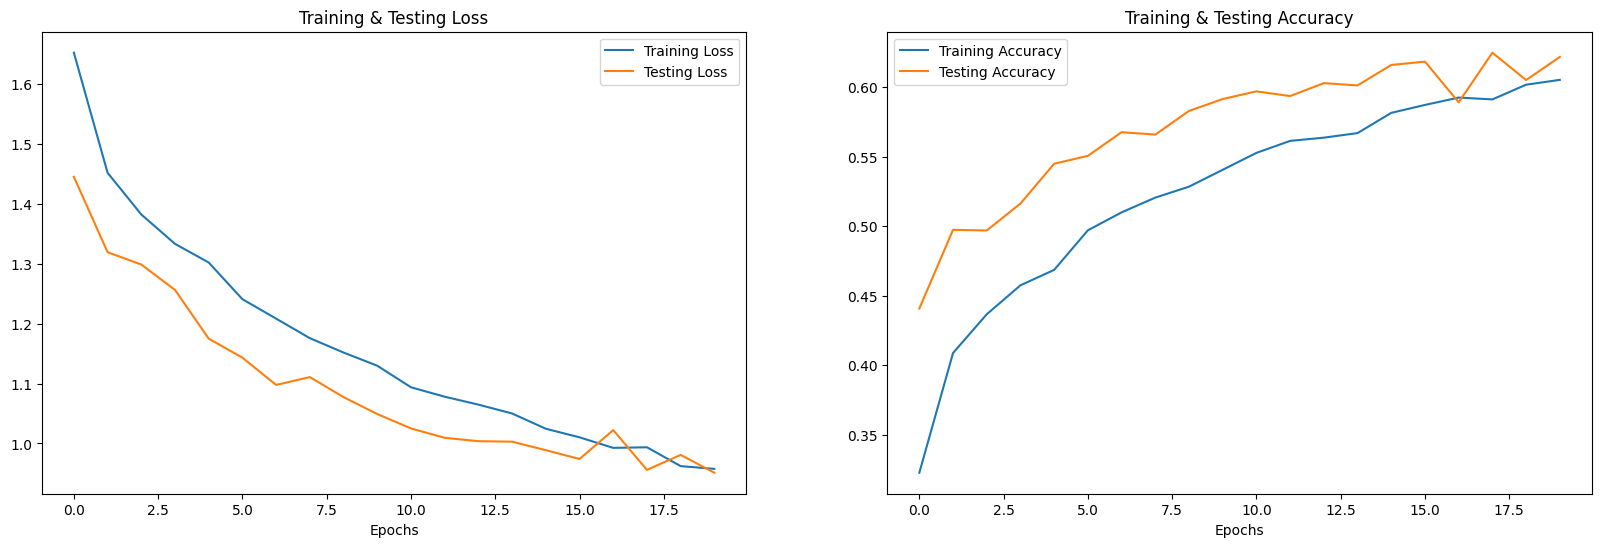

In [164]:
# Print the accuracy of the model on the test data
print("Accuracy of our model on test data: ", model.evaluate(x_test, y_test)[1] * 100, "%")

# Plot training and testing loss, as well as training and testing accuracy across epochs
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [167]:
model_path = "./model.h5"

model.save(model_path)